In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [19]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains, udf\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'the-reddit-covid-dataset-comments.csv'
# Load the main data set into pyspark data frame 
df = spark.read.options(delimiter=",", header=True).csv(filename_data)
# df = spark.read.csv(filename_data)
# df = pd.read_csv(filename_data)
# print(df)
print(f'Count of ALL data in dataset = {df.count()}')
print('Data frame type: ' + str(type(df)))

# df.drop(col('permalink'))

df.show()

Count of ALL data in dataset = 50909729
Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+--------------------+--------------------+------------------+--------------+-----------+--------------------+--------------------+---------------+--------------------+
|                type|                  id|        subreddit.id|    subreddit.name|subreddit.nsfw|created_utc|           permalink|                body|      sentiment|               score|
+--------------------+--------------------+--------------------+------------------+--------------+-----------+--------------------+--------------------+---------------+--------------------+
|             comment|             hi1vsag|               2riyy|              nova|         false| 1635206399|https://old.reddi...|When you schedule...|            0.0|                   2|
|             comment|             hi1vs7i|               2qhov|         vancouver|         false| 1635206397|https://old.reddi...|Didn't sto

In [3]:
filtered_data = df.filter(df.type == 'comment')#.\
filtered_data = filtered_data.drop('permalink')
                # filter((df.score.isNull()) | (df.score > 0))

filtered_data = filtered_data.withColumnRenamed('subreddit.nsfw', 'nsfw')
filtered_data = filtered_data.withColumnRenamed('subreddit.id', 'subId')
filtered_data = filtered_data.withColumnRenamed('subreddit.name', 'subName')

filtered_data = filtered_data.filter(col('nsfw') == 'false').drop('nsfw')

filtered_data = filtered_data.withColumn('score', filtered_data['score'].cast('integer'))
filtered_data = filtered_data.withColumn('created_utc', filtered_data['created_utc'].cast('integer'))
filtered_data = filtered_data.withColumn('sentiment', filtered_data['sentiment'].cast('float'))

print('Columns overview')
pd.DataFrame(filtered_data.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,type,string
1,id,string
2,subId,string
3,subName,string
4,created_utc,int
5,body,string
6,sentiment,float
7,score,int


In [4]:
filtered_data.show()
# print(filtered_data.count())

# print('Columns overview')
# pd.DataFrame(filtered_data.dtypes, columns = ['Column Name','Data type'])

+-------+-------+------+--------------------+-----------+--------------------+---------+-----+
|   type|     id| subId|             subName|created_utc|                body|sentiment|score|
+-------+-------+------+--------------------+-----------+--------------------+---------+-----+
|comment|hi1vsag| 2riyy|                nova| 1635206399|When you schedule...|      0.0|    2|
|comment|hi1vs7i| 2qhov|           vancouver| 1635206397|Didn't stop price...|     NULL| NULL|
|comment|hi1vs5n| 2qwzb|            pregnant| 1635206397|I’m just waiting ...|     NULL| NULL|
|comment|hi1vs5v| 2qixm|            startrek| 1635206397|*The first duty o...|     NULL| NULL|
|comment|hi1vs0l| 2qsf3|             ontario| 1635206395|Compare BC to Ont...|      0.0|   -2|
|comment|hi1vrtk| 2qh0f|       entertainment| 1635206393|"Sheeran didn't m...|     NULL| NULL|
|comment|hi1vrsk| 2qh4r|          conspiracy| 1635206392|I see a lot of po...|     NULL| NULL|
|comment|hi1vrnr|2iokxd|  lockdownskepticism| 1635

In [5]:
Dict_Null = {col:filtered_data.filter(filtered_data[col].isNull()).count() for col in filtered_data.columns}

Dict_Null

{'type': 0,
 'id': 0,
 'subId': 0,
 'subName': 0,
 'created_utc': 0,
 'body': 0,
 'sentiment': 9338188,
 'score': 8836250}

In [9]:
filtered_data = filtered_data.na.drop()
filtered_data.show()
print(f'Count rows after delete null values = {filtered_data.count()}')

+-------+-------+------+--------------------+-----------+--------------------+---------+-----+
|   type|     id| subId|             subName|created_utc|                body|sentiment|score|
+-------+-------+------+--------------------+-----------+--------------------+---------+-----+
|comment|hi1vsag| 2riyy|                nova| 1635206399|When you schedule...|      0.0|    2|
|comment|hi1vs0l| 2qsf3|             ontario| 1635206395|Compare BC to Ont...|      0.0|   -2|
|comment|hi1vrnr|2iokxd|  lockdownskepticism| 1635206391|And think about h...|  -0.8413|   29|
|comment|hi1vrou| 384mz|         antivaxxers| 1635206391|I don’t know anyo...|  -0.9191|    1|
|comment|hi1vrg2| 2qh4r|          conspiracy| 1635206388|BS. Not a fear ca...|  -0.9625|    1|
|comment|hi1vre5| 2s5sb|      torontoraptors| 1635206387|Idk if they have ...|  -0.0516|    3|
|comment|hi1vqy4| 2tasy|personalfinanceca...| 1635206381|I got some crappy...|   0.6604|    2|
|comment|hi1vqh5| 2qhpn|             economy| 1635

In [10]:
from pyspark.sql.functions import round

filtered_data = filtered_data.withColumn('sentiment', round(col('sentiment'), 4))
filtered_data = filtered_data.drop('type')
filtered_data = filtered_data.drop('id')
filtered_data = filtered_data.drop('subId')
filtered_data.show()

+--------------------+-----------+--------------------+---------+-----+
|             subName|created_utc|                body|sentiment|score|
+--------------------+-----------+--------------------+---------+-----+
|                nova| 1635206399|When you schedule...|      0.0|    2|
|             ontario| 1635206395|Compare BC to Ont...|      0.0|   -2|
|  lockdownskepticism| 1635206391|And think about h...|  -0.8413|   29|
|         antivaxxers| 1635206391|I don’t know anyo...|  -0.9191|    1|
|          conspiracy| 1635206388|BS. Not a fear ca...|  -0.9625|    1|
|      torontoraptors| 1635206387|Idk if they have ...|  -0.0516|    3|
|personalfinanceca...| 1635206381|I got some crappy...|   0.6604|    2|
|             economy| 1635206375|Pretty sure the e...|   0.6705|    1|
|         redscarepod| 1635206372|Lol it’s kinda fu...|   0.4417|    6|
|               korea| 1635206370|It's racist in th...|  -0.8481|    9|
|             alberta| 1635206367|When it comes to ...|   0.4215

In [11]:
add_time_filtered = filtered_data.withColumn('created_utc', col('created_utc').cast(TimestampType()).cast(DateType()))
add_time_filtered.show()

+--------------------+-----------+--------------------+---------+-----+
|             subName|created_utc|                body|sentiment|score|
+--------------------+-----------+--------------------+---------+-----+
|                nova| 2021-10-25|When you schedule...|      0.0|    2|
|             ontario| 2021-10-25|Compare BC to Ont...|      0.0|   -2|
|  lockdownskepticism| 2021-10-25|And think about h...|  -0.8413|   29|
|         antivaxxers| 2021-10-25|I don’t know anyo...|  -0.9191|    1|
|          conspiracy| 2021-10-25|BS. Not a fear ca...|  -0.9625|    1|
|      torontoraptors| 2021-10-25|Idk if they have ...|  -0.0516|    3|
|personalfinanceca...| 2021-10-25|I got some crappy...|   0.6604|    2|
|             economy| 2021-10-25|Pretty sure the e...|   0.6705|    1|
|         redscarepod| 2021-10-25|Lol it’s kinda fu...|   0.4417|    6|
|               korea| 2021-10-25|It's racist in th...|  -0.8481|    9|
|             alberta| 2021-10-25|When it comes to ...|   0.4215

In [12]:
stat = add_time_filtered.describe()

stat.toPandas()

,summary,subName,body,sentiment,score
0,count,8291109,8291109,8291109,8291109
1,mean,58386.73493126542,None,0.06543830584301229,12.346258383528669
2,stddev,559814.6193997489,None,58.55741936881833,8970.925352030543
3,min,0000xfyuzn,\t\tYou could write about care rationing relat...,-24.0,-1247
4,max,zzplant,🧡 2G but pre-COVID I made myself take at least...,119324.0,25829107


In [13]:
import seaborn as sns

boxplot_cols = ['sentiment', 'score']
cleaned_df = add_time_filtered

print(f"Rows count before cleaning: {cleaned_df.count()}")
for column in boxplot_cols:
    # квартили для определения выбросов
    Q1 = cleaned_df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = cleaned_df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1

    # Определение границ для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Удаление выбросов
    cleaned_df = cleaned_df.filter((cleaned_df[column] >= lower_bound) & (cleaned_df[column] <= upper_bound))
print(f"Rows count after cleaning: {cleaned_df.count()}")


Rows count before cleaning: 8291109
Rows count after cleaning: 7007103


In [14]:
cleaned_df.show()
cleaned_df_columns = list(cleaned_df.columns)
take_10 = pd.DataFrame(cleaned_df.take(500000), columns=cleaned_df_columns)
take_10.to_csv('take_500K.csv')

+--------------------+-----------+--------------------+---------+-----+
|             subName|created_utc|                body|sentiment|score|
+--------------------+-----------+--------------------+---------+-----+
|                nova| 2021-10-25|When you schedule...|      0.0|    2|
|             ontario| 2021-10-25|Compare BC to Ont...|      0.0|   -2|
|         antivaxxers| 2021-10-25|I don’t know anyo...|  -0.9191|    1|
|          conspiracy| 2021-10-25|BS. Not a fear ca...|  -0.9625|    1|
|      torontoraptors| 2021-10-25|Idk if they have ...|  -0.0516|    3|
|personalfinanceca...| 2021-10-25|I got some crappy...|   0.6604|    2|
|             economy| 2021-10-25|Pretty sure the e...|   0.6705|    1|
|         redscarepod| 2021-10-25|Lol it’s kinda fu...|   0.4417|    6|
|               korea| 2021-10-25|It's racist in th...|  -0.8481|    9|
|             alberta| 2021-10-25|When it comes to ...|   0.4215|    0|
|       beyondthebump| 2021-10-25|Any other kids I ...|   0.6331

+---------+-----+
|sentiment|count|
+---------+-----+
|  -0.9796|  215|
|  -0.5407|  127|
|  -0.2374|  174|
|  -0.8648|  149|
|   0.9421|  359|
|  -0.9103|  152|
|   0.6801| 1084|
|   0.9044|  197|
|  -0.3976|  504|
|   0.5316|   62|
|  -0.8943|  224|
|   -0.894|  134|
|  -0.5635|  220|
|   0.4791|  227|
|  -0.7092|  147|
|   0.9035|  249|
|   -0.002|   15|
|  -0.8466|  385|
|  -0.2911|  447|
|   -0.627|  128|
+---------+-----+
only showing top 20 rows



<Axes: xlabel='sentiment', ylabel='count'>

Text(0.5, 1.0, 'Values frequency of sentiment column')

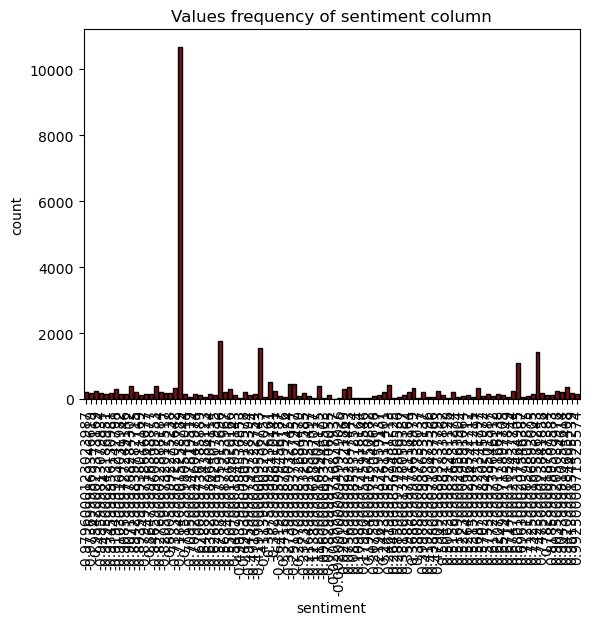

+-----+-------+
|score|  count|
+-----+-------+
|   -1| 133621|
|    1|2474994|
|    6| 268997|
|    3| 779296|
|   -5|  32892|
|    5| 351319|
|    9| 139806|
|    4| 371953|
|    8| 170101|
|    7| 211057|
|   -4|  40451|
|   10| 116541|
|   -2|  78258|
|   11|  98379|
|    2|1349687|
|   -3|  47247|
|    0| 342504|
+-----+-------+



<Axes: xlabel='score', ylabel='count'>

Text(0.5, 1.0, 'Values frequency of score column')

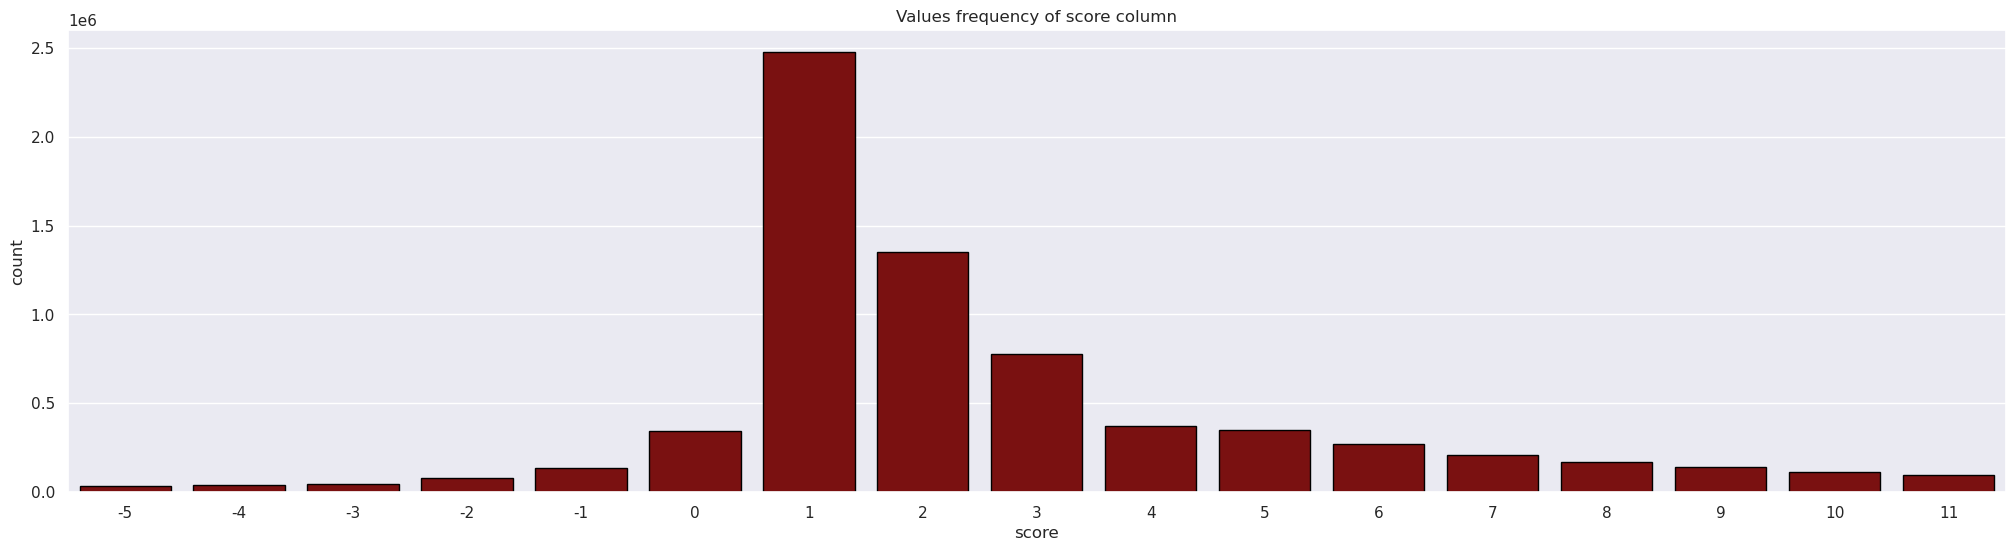

In [15]:
for column in boxplot_cols:
    cleaned_df.groupBy(column).count().show()
    grouped_data = cleaned_df.groupBy(column).count()
    data = grouped_data.limit(100).collect()
    
    pd_data = pd.DataFrame(data, columns=grouped_data.columns)
    pd_colums_names = list(pd_data.columns)

    fig, ax = plt.subplots(1,1)
    sns.set(rc={'figure.figsize':(25,6)})
    sns.barplot(x=pd_colums_names[0], y=pd_colums_names[1], data=pd_data, color='darkred', edgecolor='black')

    if len(str(pd_data[pd_colums_names[0]][0])) >= 4:
        xticks = ax.get_xticks()
        xticklabels = [x.get_text() for x in ax.get_xticklabels()]
        _ = ax.set_xticks(xticks, xticklabels, rotation=90)
    
    plt.title(f"Values frequency of {column} column")
    plt.show()

Calculated quantilies for sentiment
Q1: -0.42149999737739563 
Q3: 0.49390000104904175 
IQR: 0.9153999984264374 
Lower: 0 
Upper: 1.8669999986886978


{'whiskers': [<matplotlib.lines.Line2D at 0x7f04bd3aead0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f04bd3bd210>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f04bd34df10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f04bd3bf310>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f04bd3cc310>],
 'means': []}

Text(0.5, 1.0, 'Boxplot for sentiment')

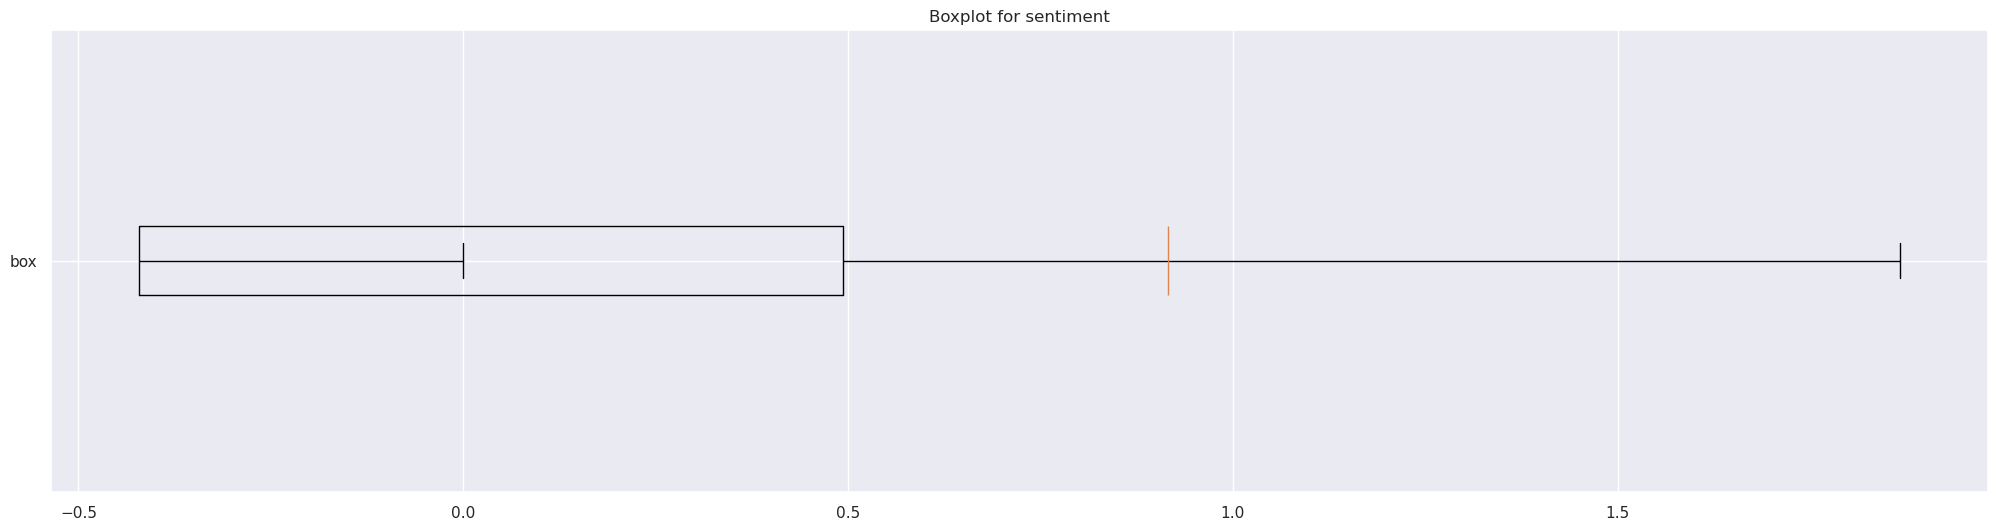

Calculated quantilies for score
Q1: 1 
Q3: 3 
IQR: 2 
Lower: 0 
Upper: 6.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f04bd10f790>,
 'caps': [<matplotlib.lines.Line2D at 0x7f04bd121d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f04bd22f290>],
 'medians': [<matplotlib.lines.Line2D at 0x7f04bd123dd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f04bd138f10>],
 'means': []}

Text(0.5, 1.0, 'Boxplot for score')

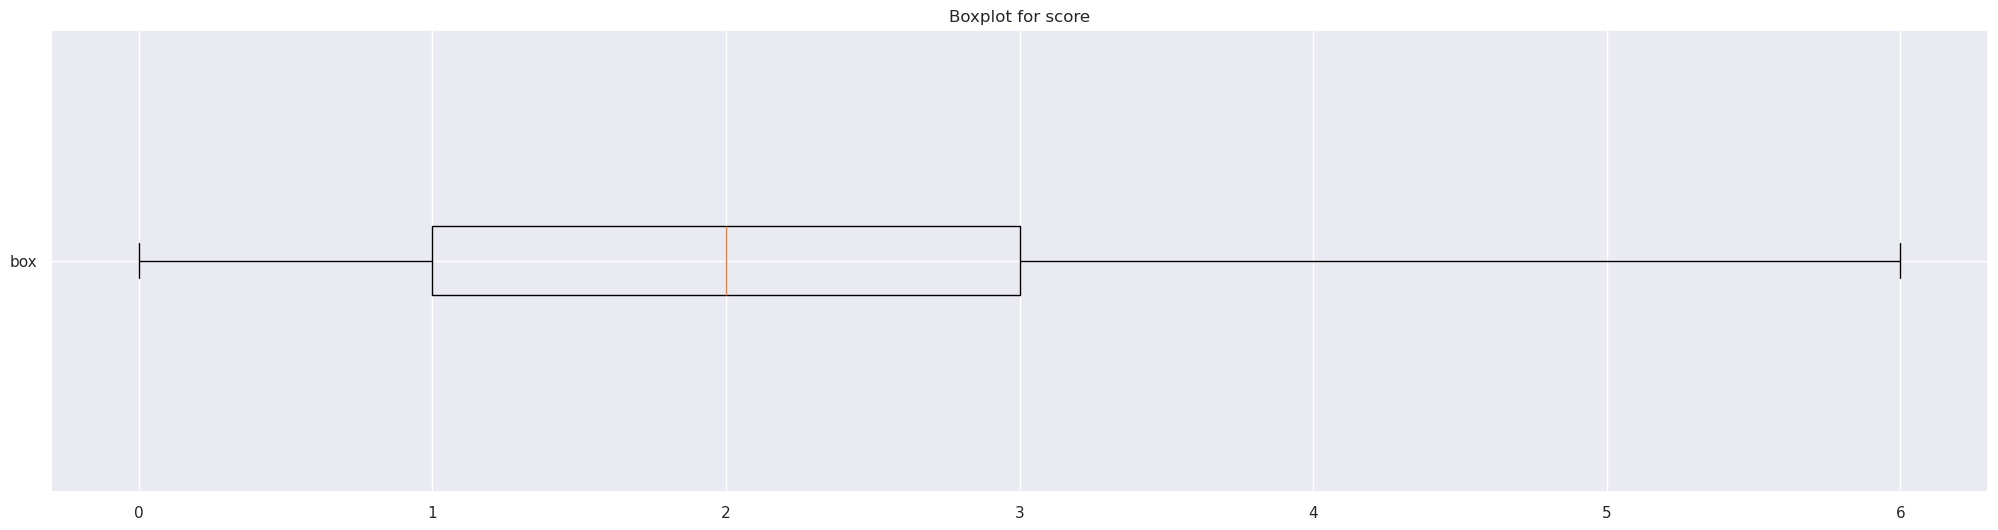

In [16]:
from pyspark.sql.functions import percentile_approx
import numpy as np


for column in boxplot_cols:
    # Собрем данные для усатого ящика  
    precentiles = cleaned_df.select(percentile_approx(column, [0.25, 0.75], 1000000).alias("quantiles")).collect()[0]
    
    # Определим квартили
    Q1 = precentiles[0][0]
    Q3 = precentiles[0][1]
    IQR = Q3 - Q1

    # Определим границы для усатых ящиков
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # lower_bound = Q1 - d_min
    # upper_bound = d_max - Q3
    
    if lower_bound < 0:
        lower_bound = 0
        
    # if upper_bound == 0:
    #     upper_bound = Q3

    
    print(f"Calculated quantilies for {column}\n"
          f"Q1: {Q1} \n"
          f"Q3: {Q3} \n"
          f"IQR: {IQR} \n"
          f"Lower: {lower_bound} \n"
          f"Upper: {upper_bound}")

    item = {"label": 'box', 
            "med": IQR, 
            "q1": Q1, 
            "q3": Q3, 
            "whislo": lower_bound, 
            "whishi": upper_bound, 
            "fliers": []}
    
    #item["cilo"] = 5.3 # not required
    #item["cihi"] = 5.7 # not required
    
    stats = [item]
    
    fig, axes = plt.subplots(1, 1)
    axes.bxp(stats, vert=False, showmeans=False, showfliers=True)
    axes.set_title(f'Boxplot for {column}')
    # y_axis = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    # y_values = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    # plt.yticks(y_axis, y_values)
    plt.show()

In [17]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler


# Выбираем только числовые признаки
# Создаем вектор из числовых признаков
assembler = VectorAssembler(inputCols=boxplot_cols, outputCol="features")
assembled_df = assembler.transform(cleaned_df)

# Вычисляем корреляцию
correlation_matrix = Correlation.corr(assembled_df, "features").head()

assembled_df.show()

+--------------------+-----------+--------------------+---------+-----+--------------------+
|             subName|created_utc|                body|sentiment|score|            features|
+--------------------+-----------+--------------------+---------+-----+--------------------+
|                nova| 2021-10-25|When you schedule...|      0.0|    2|           [0.0,2.0]|
|             ontario| 2021-10-25|Compare BC to Ont...|      0.0|   -2|          [0.0,-2.0]|
|         antivaxxers| 2021-10-25|I don’t know anyo...|  -0.9191|    1|[-0.9190999865531...|
|          conspiracy| 2021-10-25|BS. Not a fear ca...|  -0.9625|    1|[-0.9624999761581...|
|      torontoraptors| 2021-10-25|Idk if they have ...|  -0.0516|    3|[-0.0516000017523...|
|personalfinanceca...| 2021-10-25|I got some crappy...|   0.6604|    2|[0.66039997339248...|
|             economy| 2021-10-25|Pretty sure the e...|   0.6705|    1|[0.67049998044967...|
|         redscarepod| 2021-10-25|Lol it’s kinda fu...|   0.4417|    6

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

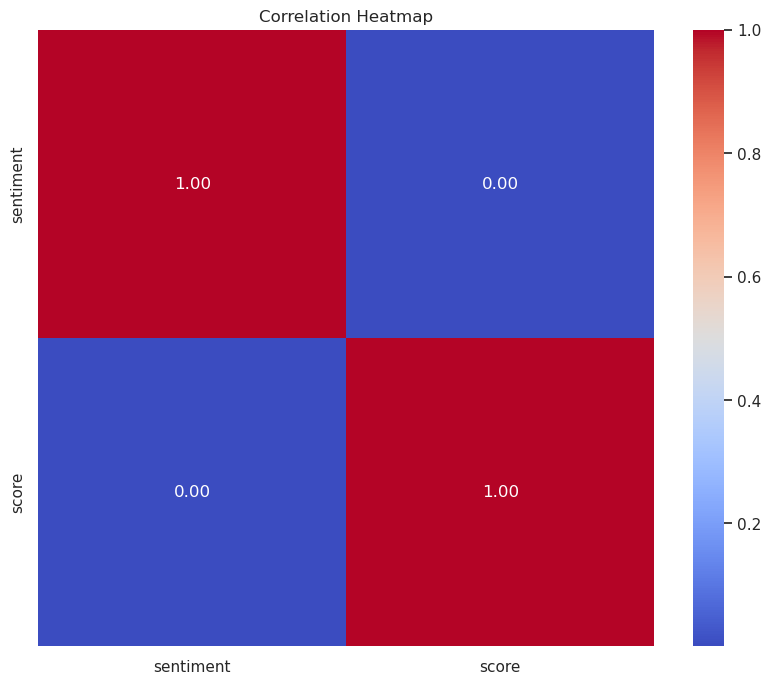

In [18]:
# Извлекаем матрицу корреляции из результатов
corr_matrix = correlation_matrix[0].toArray()

# И heat'em'up!
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, xticklabels=boxplot_cols, yticklabels=boxplot_cols)
plt.title("Correlation Heatmap")
plt.show()